In [3]:
import pickle
import os
import numpy as np

from utils.funs import scores

from transformers import AutoModelForCausalLM

In [4]:
def getscoresGPTneo(d,l,h,dh,model):
    """
    Args:
        - d (int) : embeddding dimension.
        - l (int) : total number of layers
        - h (int) : number of heads.
        - dh (int) : embedding dimension per head.
        - model () : full model.

    Returns:
        - SList (numpy ndarray) : List of Symmetric (S) scores.
        - NList (numpy ndarray) : List of Skew-symmetric (N) scores.
    """

    SList = np.zeros((l,h))
    NList = np.zeros((l,h))
    
    # retrieve all block instances (each layer in the GPT architecture)
    layers = model.transformer.h

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.attn.attention

        # access parameters of Conv1D
        Wq = self_attention.q_proj._parameters["weight"].T.view(d,h,dh).detach().numpy()
        Wk = self_attention.k_proj._parameters["weight"].T.view(d,h,dh).detach().numpy()

        for j in range(h):
            
            # calculate the association matrix M
            M = Wq[:,j,:] @ Wk[:,j,:].T
            # compute symmetry and skew-symmetry scores
            S, N = scores(M)
            SList[i,j], NList[i,j] = S, N

    return  SList, NList

In [5]:
"""
- KEY (str): model name
- VALUES (list): [layers (int), 
                  embedding dim (int), 
                  heads (int), 
                  head dim (int), 
                  S scores, 
                  N scores]
"""

if os.path.isfile('../_data/fig_scores/GPTNEOmodels.pkl'):
    with open('../_data/fig_scores/GPTNEOmodels.pkl', 'rb') as file:
        models = pickle.load(file)
else: models = {}

In [10]:
'GPT neo 125m (l = 12, d = 768, h = 12)'
dh = 64
l = 12
d = 768
h = d // dh
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-125m")
S, N = getscoresGPTneo(d,l,h,dh,model)
models['GPTneo-125m'] = [l,d,h,dh,S,N]

'GPT neo 1.3b (l = 12, d = 768, h = 16)'
dh = 128
l = 24
d = 2048
h = d // dh
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")
S, N = getscoresGPTneo(d,l,h,dh,model)
models['GPTneo-1.3b'] = [l,d,h,dh,S,N]

'GPT neo 2.7b (l = 12, d = 768, h = 20)'
dh = 128
l = 32
d = 2560
h = d // dh
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-2.7B")
S, N = getscoresGPTneo(d,l,h,dh,model)
models['GPTneo-2.7b'] = [l,d,h,dh,S,N]

'save'
with open('../_data/fig_scores/GPTNEOmodels.pkl', 'wb') as file:
    pickle.dump(models, file)

AttributeError: 'GPTJAttention' object has no attribute 'attention'

(0.0, 1.0)

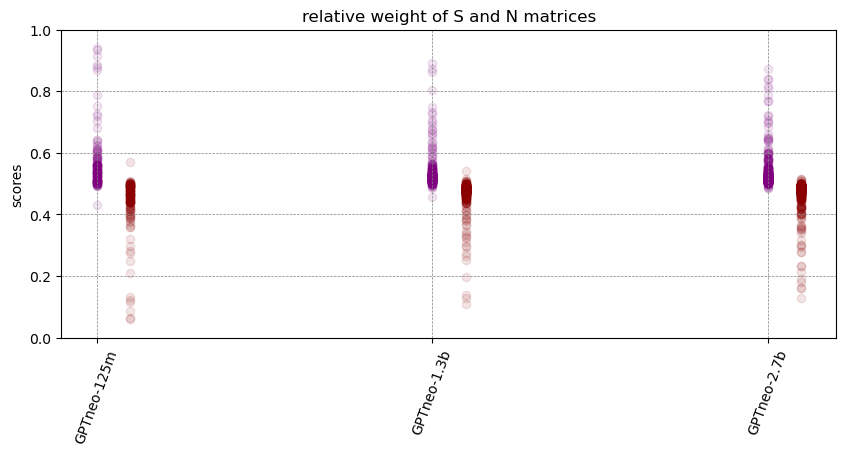

In [12]:
import matplotlib.pyplot as plt

with open('../_data/fig_scores/GPTNEOmodels.pkl', 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-2].flatten() for key in list(models.keys())]
NList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(10,4))

for i, model in enumerate(SList):
    
    plt.scatter(i*np.ones(SList[i].size),(SList[i].flatten()**2),color='purple',alpha=.1)
    plt.scatter(i,(SList[i].flatten()**2).mean(),color='purple')

    plt.scatter((i+.1)*np.ones(NList[i].size),(NList[i].flatten()**2),color='darkred',alpha=.1)
    plt.scatter(i+.1,(NList[i].flatten()**2).mean(),color='darkred')
    
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.title('relative weight of S and N matrices')
plt.ylabel('scores')
plt.xticks(np.arange(len(names)),names)
plt.xticks(rotation=70)
plt.ylim(0,1)